In [47]:
import os
import cv2
import random
from datetime import datetime

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers.merge import Concatenate

from utils.vqa_tools.PythonHelperTools.vqaTools.vqa import VQA

# Set VQA dataset files and parameters
# dataDir='/Volumes/Data/vqa_data'
dataDir='../vqa_data'
taskType='OpenEnded'
dataType='mscoco' # 'mscoco' for real and 'abstract_v002' for abstract
dataSubType='train2014'
annFile='%s/Annotations/v2_%s_%s_annotations.json'%(dataDir, dataType, dataSubType)
quesFile='%s/Questions/v2_%s_%s_%s_questions.json'%(dataDir, taskType, dataType, dataSubType)
imgDir = '%s/Images/%s/' %(dataDir, dataSubType)

def get_Inception_v3_pre_trained_model():
    
#     vision_model = Sequential()
    print('{} - Starting to get base inception v3 model'.format(datetime.now()))
    inception_base_model = InceptionV3(weights='imagenet', include_top=False)
#     x = inception_base_model.output
    inception_base_model = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)


#     print('{} - Adding base model'.format(datetime.now()))
#     vision_model.add(inception_base_model)
    
    image_input = Input(shape=(224, 224, 3))
#     encoded_image = vision_model(image_input)
    encoded_image = inception_base_model(image_input)
    
    print('{} - Processing embedded model'.format(datetime.now()))
    question_input = Input(shape=(100,), dtype='int32')
    embedded_question = Embedding(input_dim=10000, output_dim=512, input_length=30)(question_input)
    encoded_question = LSTM(256)(embedded_question)
    
    # Let's concatenate the question vector and the image vector:
#     merged = keras.layers.concatenate([encoded_question, encoded_image])
    print('{} - Merging model'.format(datetime.now()))
    merged = Concatenate([encoded_question, encoded_image])

    # And let's train a logistic regression over 1000 words on top:
    output = Dense(1000, activation='softmax')(merged)

    # This is our final model:
    print('{} - final model'.format(datetime.now()))
    vqa_model = Model(inputs=[image_input, question_input], outputs=output)
    
    return vqa_model
    

In [48]:
print('{} - Loading VQA dataset'.format(datetime.now()))
vqa = VQA(annFile, quesFile)
annIds = vqa.getQuesIds(quesTypes='how many');
anns = vqa.loadQA(annIds)
# print("answer from anns: ", anns[0]['answers'][0]['answer'])
print("answer(random) from anns: ", random.choice(anns[0]['answers'])['answer'])
# print("anser from qa: ", vqa.qa[393227002]['answers'][0]['answer'])
print("querstoin from qqa: ", vqa.qqa[anns[0]['question_id']]['question'])


2017-08-04 01:56:02.656440 - Loading VQA dataset
loading VQA annotations and questions into memory...
0:00:15.809394
creating index...
index created!
answer(random) from anns:  1
querstoin from qqa:  How many tattoos can be seen on this man's body?


(224, 224, 3)


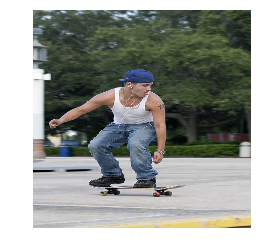

In [49]:
image_list = []
question_list = []
answer_list = []



question_list.append(vqa.qqa[anns[0]['question_id']]['question'])
answer_list.append(random.choice(anns[0]['answers'])['answer']) 

imgId = anns[0]['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'



file = imgDir + imgFilename
if os.path.isfile(file):
#     im = cv2.resize(cv2.imread(file), (299, 299))
#     im = im.astype(np.float32, copy=False)
    
    im = np.asarray(cv2.imread(file))[:,:,::-1]
#     im = central_crop(im, 0.875)
    im = cv2.resize(im, (224, 224))
#     im = im.reshape(-1,299,299,3)
    
#     im = io.imread(file)
    
    print(im.shape)
    plt.imshow(im)
    plt.axis('off')
    plt.show()
    image_list.append(im)

# if os.path.isfile(imgDir + imgFilename):
#     I = io.imread(imgDir + imgFilename)
#     plt.imshow(I)
#     plt.axis('off')
#     plt.show()


In [50]:

verbose = 1
if verbose: print("\n\n\nLoading model .......")
model = get_Inception_v3_pre_trained_model()

# Training
epoch = 1
batch_size = 1

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
if verbose: print("\n\n\nTraining model .......")
train_history = model.fit(x=[image_list, question_list], y=answer_list, 
                              epochs=epoch, batch_size=batch_size, verbose=2)
if verbose: print("\n\n\nDone.......")




Loading model .......
2017-08-04 01:57:01.775261 - Starting to get base inception v3 model


NameError: name 'x' is not defined